# CNN Model for BP estimation using PPG only

## Imports and setup

In [1]:
import sys, os, glob
sys.path.append(os.path.abspath(".."))  # go one level up (project root)

import numpy as np
import torch.nn as nn
import random
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt

from torch.utils.data import TensorDataset, DataLoader
from dataset.utils import clean_labels, split_dataset, plot_bp_distribution
from models.cnn_bp_model import CNN_BP_Estimator

In [2]:
# Reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

# Device config
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")   # for Apple Silicon (Metal Performance Shaders)
else:
    device = torch.device("cpu")

print(f"✅ Using device: {device}")

# Performance
torch.backends.cudnn.benchmark = True   # lets cudnn choose best kernel for convs
torch.backends.cudnn.deterministic = False  # fine since we fix seeds


✅ Using device: cuda


## Load Data

In [44]:
# Choose dataset type
dataset_type = "ppg_ecg"   # or "ppg_ecg"

# Gather all matching .npz files
npz_files = sorted(glob.glob(f"../data/processed/*_{dataset_type}.npz"))
print(f"Found {len(npz_files)} files for {dataset_type}")

# Create lists to hold data
X_list, y_list = [], []

for file in npz_files:
    data = np.load(file)
    X = data["X"].astype(np.float32)   # ✅ convert to float32
    y = data["y"].astype(np.float32)
    X_list.append(X)
    y_list.append(y)

# Merge
X = np.concatenate(X_list, axis=0)
y = np.concatenate(y_list, axis=0)

print(f"Merged dataset: X={X.shape}, y={y.shape}, dtype={X.dtype}")

# Save merged dataset
out_path = f"../data/processed/all_{dataset_type}.npz"
np.savez_compressed(out_path, X=X, y=y)
print(f"✅ Saved merged dataset to {out_path}")

Found 12 files for ppg_ecg
Merged dataset: X=(3507740, 2, 375), y=(3507740, 2), dtype=float32
✅ Saved merged dataset to ../data/processed/all_ppg_ecg.npz


## Remove outliers and clean labels

In [45]:
print("Before cleaning:", X.shape)
print("SBP range:", y[:, 0].min(), "-", y[:, 0].max())
print("DBP range:", y[:, 1].min(), "-", y[:, 1].max())

# Clean labels
X, y = clean_labels(X, y)
print("After cleaning:", X.shape)
print("SBP range:", y[:, 0].min(), "-", y[:, 0].max())
print("DBP range:", y[:, 1].min(), "-", y[:, 1].max())

Before cleaning: (3507740, 2, 375)
SBP range: 55.291473 - 199.51859
DBP range: 50.0 - 191.42117
🧹 Removed 81857 outlier segments (2.33%)
✅ Remaining: 3425883
After cleaning: (3425883, 2, 375)
SBP range: 80.0 - 179.99867
DBP range: 50.0 - 119.99776


## Split dataset into train, val, test sets

We'll also save them for future use.

In [46]:
# Split dataset into train, val, test sets
(X_train, y_train), (X_val, y_val), (X_test, y_test) = split_dataset(X, y, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15)
print(f"Train: X={X_train.shape}, y={y_train.shape}")
print(f"Val:   X={X_val.shape}, y={y_val.shape}")
print(f"Test:  X={X_test.shape}, y={y_test.shape}")

Train: 2398118 | Val: 513882 | Test: 513883
Train: X=(2398118, 2, 375), y=(2398118, 2)
Val:   X=(513882, 2, 375), y=(513882, 2)
Test:  X=(513883, 2, 375), y=(513883, 2)


In [47]:
print("SBP range (train):", y_train[:,0].min(), "-", y_train[:,0].max())
print("DBP range (train):", y_train[:,1].min(), "-", y_train[:,1].max())
print("SBP range (val):", y_val[:,0].min(), "-", y_val[:,0].max())
print("SBP range (test):", y_test[:,0].min(), "-", y_test[:,0].max())

SBP range (train): 80.0 - 179.99867
DBP range (train): 50.0 - 119.99776
SBP range (val): 80.001526 - 179.99052
SBP range (test): 80.0 - 179.99481


In [48]:
# Save the splits
np.savez_compressed(f"../data/processed/ppg_ecg_clean_train.npz", X=X_train, y=y_train)
np.savez_compressed(f"../data/processed/ppg_ecg_clean_val.npz", X=X_val, y=y_val)
np.savez_compressed(f"../data/processed/ppg_ecg_clean_test.npz", X=X_test, y=y_test)
print("✅ Saved train, val, test splits.")

✅ Saved train, val, test splits.


## Load data from saved files

 (skip above cells if this is the case)

In [ ]:
# Load data from saved files

train_data = np.load(f"../data/processed/ppg_clean_train.npz")
X_train, y_train = train_data["X"], train_data["y"]
val_data = np.load(f"../data/processed/ppg_clean_val.npz")
X_val, y_val = val_data["X"], val_data["y"]
test_data = np.load(f"../data/processed/ppg_clean_test.npz")
X_test, y_test = test_data["X"], test_data["y"]
print(f"Train: X={X_train.shape}, y={y_train.shape}")
print(f"Val:   X={X_val.shape}, y={y_val.shape}")
print(f"Test:  X={X_test.shape}, y={y_test.shape}")

# Delete unused variables to free memory
del train_data, val_data, test_data

print("✅ Loaded train, val, test splits from saved files.")

Train: X=(2398118, 375), y=(2398118, 2)
Val:   X=(513882, 375), y=(513882, 2)
Test:  X=(513883, 375), y=(513883, 2)


NameError: name 'X' is not defined

## Data Preparation

In [4]:
# Convert to torch tensors
X_train_t = torch.tensor(X_train).unsqueeze(1)  # Add channel dimension
y_train_t = torch.tensor(y_train)

X_val_t = torch.tensor(X_val).unsqueeze(1)
y_val_t = torch.tensor(y_val)

X_test_t = torch.tensor(X_test).unsqueeze(1)
y_test_t = torch.tensor(y_test)

print(f"Train tensor: X={X_train_t.shape}, y={y_train_t.shape}, dtype={X_train_t.dtype}")
print(f"Val tensor:   X={X_val_t.shape}, y={y_val_t.shape}, dtype={X_val_t.dtype}")
print(f"Test tensor:  X={X_test_t.shape}, y={y_test_t.shape}, dtype={X_test_t.dtype}")


Train tensor: X=torch.Size([2398118, 1, 375]), y=torch.Size([2398118, 2]), dtype=torch.float32
Val tensor:   X=torch.Size([513882, 1, 375]), y=torch.Size([513882, 2]), dtype=torch.float32
Test tensor:  X=torch.Size([513883, 1, 375]), y=torch.Size([513883, 2]), dtype=torch.float32


In [5]:
# Replace NaNs and Infs with 0s
X_train_t = torch.nan_to_num(X_train_t, nan=0.0, posinf=0.0, neginf=0.0)
X_val_t = torch.nan_to_num(X_val_t, nan=0.0, posinf=0.0, neginf=0.0)
X_test_t = torch.nan_to_num(X_test_t, nan=0.0, posinf=0.0, neginf=0.0)

In [6]:
# Create DataLoaders

batch_size=512

train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
test_dataset = TensorDataset(X_test_t, y_test_t)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
print(f"✅ Created DataLoaders with batch size {batch_size}")


✅ Created DataLoaders with batch size 512


## Model Training

### Import and initialize model

In [7]:
model = CNN_BP_Estimator(input_channels=1)
model = model.to(device)
print(model)
print(f"✅ Model loaded on {device}")

CNN_BP_Estimator(
  (encoder): Sequential(
    (0): Conv1d(1, 16, kernel_size=(7,), stride=(1,), padding=(3,))
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv1d(16, 32, kernel_size=(5,), stride=(1,), padding=(2,))
    (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (9): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (13): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
   

In [8]:
# (or load the best saved model)
best_model_path = "../checkpoints/best_cnn_model.pt"
model.load_state_dict(torch.load(best_model_path, map_location=device, weights_only=True))
model = model.to(device)
print(model)
print(f"✅ Loaded best model from {best_model_path} on {device}")

CNN_BP_Estimator(
  (encoder): Sequential(
    (0): Conv1d(1, 16, kernel_size=(7,), stride=(1,), padding=(3,))
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv1d(16, 32, kernel_size=(5,), stride=(1,), padding=(2,))
    (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (9): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (13): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
   

### Define optimizer and loss function

In [9]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
print("✅ Optimizer and loss function defined.")

config = {
    "batch_size": batch_size,
    "epochs": 30,
    "learning_rate": 1e-3,
    "optimizer": "Adam",
    "loss": "MSELoss",
} # config dictionary - useful for logging

print(config)

✅ Optimizer and loss function defined.
{'batch_size': 512, 'epochs': 30, 'learning_rate': 0.001, 'optimizer': 'Adam', 'loss': 'MSELoss'}


Beforemoving to training, let's do a sanity check - dummy forward pass.

In [10]:
X_batch, y_batch = next(iter(train_loader))
X_batch, y_batch = X_batch.to(device), y_batch.to(device)

preds = model(X_batch)
loss = criterion(preds, y_batch)
loss.backward()

print("✅ Forward + backward pass succeeded.")

✅ Forward + backward pass succeeded.


Let's also define a rmse function to use as a metric.

In [11]:

def rmse(pred, target):
    return torch.sqrt(torch.mean((pred - target) ** 2))

### Training Loop

In [12]:
# Make sure checkpoint directory exists
ckpt_dir = "../checkpoints"
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)
    print(f"Created checkpoint directory at {ckpt_dir}")
else:
    print(f"Checkpoint directory exists at {ckpt_dir}")

Checkpoint directory exists at ../checkpoints


In [13]:
num_epochs = 30
best_val_loss = float("inf")

for epoch in range(num_epochs):
    # ------------------------
    # 🔹 TRAINING PHASE
    # ------------------------
    model.train()
    train_loss = 0.0

    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False)
    for X_batch, y_batch in train_bar:
        X_batch = X_batch.to(device, non_blocking=True)
        y_batch = y_batch.to(device, non_blocking=True)

        optimizer.zero_grad()
        preds = model(X_batch)
        loss = criterion(preds, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * X_batch.size(0)
        train_bar.set_postfix({"Batch Loss": loss.item()})

    avg_train_loss = train_loss / len(train_loader.dataset)

    # ------------------------
    # 🔹 VALIDATION PHASE
    # ------------------------
    model.eval()
    val_loss = 0.0
    sbp_rmse_total, dbp_rmse_total = 0.0, 0.0

    val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]", leave=False)
    with torch.no_grad():
        for X_batch, y_batch in val_bar:
            X_batch = X_batch.to(device, non_blocking=True)
            y_batch = y_batch.to(device, non_blocking=True)

            preds = model(X_batch)
            loss = criterion(preds, y_batch)

            val_loss += loss.item() * X_batch.size(0)

            # Compute SBP and DBP RMSE for each batch
            sbp_rmse = rmse(preds[:, 0], y_batch[:, 0])
            dbp_rmse = rmse(preds[:, 1], y_batch[:, 1])
            sbp_rmse_total += sbp_rmse.item() * X_batch.size(0)
            dbp_rmse_total += dbp_rmse.item() * X_batch.size(0)

            val_bar.set_postfix({"Val Loss": loss.item(),
                                 "SBP_RMSE": sbp_rmse.item(),
                                 "DBP_RMSE": dbp_rmse.item()})

    avg_val_loss = val_loss / len(val_loader.dataset)
    avg_sbp_rmse = sbp_rmse_total / len(val_loader.dataset)
    avg_dbp_rmse = dbp_rmse_total / len(val_loader.dataset)

    # ------------------------
    # 🔹 LOGGING + CHECKPOINT
    # ------------------------
    print(f"Epoch [{epoch+1}/{num_epochs}] | "
          f"Train Loss: {avg_train_loss:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | "
          f"SBP RMSE: {avg_sbp_rmse:.2f} | DBP RMSE: {avg_dbp_rmse:.2f}")

    # Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), os.path.join(ckpt_dir, "best_cnn_model_bs512.pt"))
        print(f"✅ Saved new best model at epoch {epoch+1}")

Epoch [1/30] | Train Loss: 144.5097 | Val Loss: 125.9051 | SBP RMSE: 13.51 | DBP RMSE: 8.30
✅ Saved new best model at epoch 1


Epoch [2/30] | Train Loss: 141.6755 | Val Loss: 125.0027 | SBP RMSE: 13.46 | DBP RMSE: 8.28
✅ Saved new best model at epoch 2


Epoch [3/30] | Train Loss: 139.3012 | Val Loss: 123.9888 | SBP RMSE: 13.40 | DBP RMSE: 8.25
✅ Saved new best model at epoch 3


KeyboardInterrupt: 

## Model Evaluation

### Load the best model

In [14]:
# Load the best model
best_model_path = "../checkpoints/best_cnn_model_bs512.pt"
model.load_state_dict(torch.load(best_model_path, map_location=device, weights_only=True))
model.eval()

print(f"✅ Loaded best model from {best_model_path}")

✅ Loaded best model from ../checkpoints/best_cnn_model_bs512.pt


### Evaluate on the test set

In [15]:
model.eval()
test_loss = 0.0
sbp_rmse_total, dbp_rmse_total = 0.0, 0.0

all_preds, all_targets = [], []

test_bar = tqdm(test_loader, desc='Evaluating on the Test Set', leave=True)

with torch.no_grad():
    for X_batch, y_batch in test_bar:
        X_batch = X_batch.to(device, non_blocking=True)
        y_batch = y_batch.to(device, non_blocking=True)
        
        preds = model(X_batch)
        loss = criterion(preds, y_batch)
        test_loss += loss.item() * X_batch.size(0)
        
        # Compute batch RMSEs
        sbp_rmse = rmse(preds[:, 0], y_batch[:, 0])
        dbp_rmse = rmse(preds[:, 1], y_batch[:, 1])
        sbp_rmse_total += sbp_rmse.item() * X_batch.size(0)
        dbp_rmse_total += dbp_rmse.item() * X_batch.size(0)

        all_preds.append(preds.cpu().numpy())
        all_targets.append(y_batch.cpu().numpy())

        # 🔹 Live progress metrics
        test_bar.set_postfix({
            "Loss": f"{loss.item():.4f}",
            "SBP_RMSE": f"{sbp_rmse.item():.2f}",
            "DBP_RMSE": f"{dbp_rmse.item():.2f}"
        })

# Combine all batches
all_preds = np.vstack(all_preds)
all_targets = np.vstack(all_targets)

avg_test_loss = test_loss / len(test_loader.dataset)
avg_sbp_rmse = sbp_rmse_total / len(test_loader.dataset)
avg_dbp_rmse = dbp_rmse_total / len(test_loader.dataset)

print(f"✅ Test Results — Loss: {avg_test_loss:.4f} | "
      f"SBP RMSE: {avg_sbp_rmse:.2f} | DBP RMSE: {avg_dbp_rmse:.2f}")

Evaluating on the Test Set: 100%|██████████| 1004/1004 [00:30<00:00, 33.10it/s, Loss=127.8292, SBP_RMSE=13.85, DBP_RMSE=7.99]

✅ Test Results — Loss: 124.3199 | SBP RMSE: 13.40 | DBP RMSE: 8.28


### Plot predicted vs true BP values

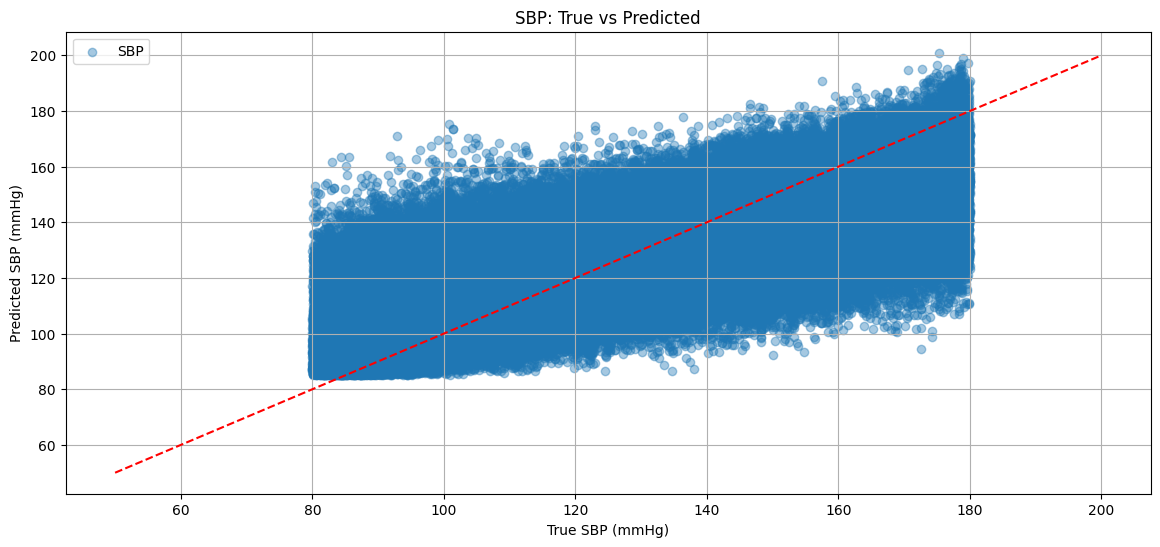

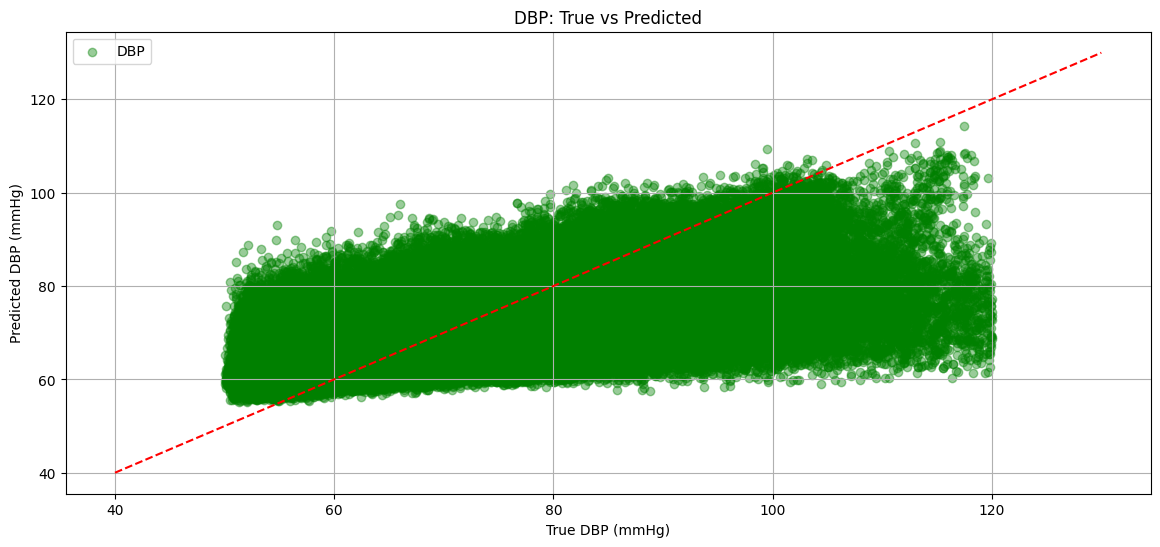

In [16]:
plt.figure(figsize=(14, 6))
plt.scatter(all_targets[:, 0], all_preds[:, 0], alpha=0.4, label="SBP")
plt.plot([50, 200], [50, 200], 'r--')
plt.xlabel("True SBP (mmHg)")
plt.ylabel("Predicted SBP (mmHg)")
plt.title("SBP: True vs Predicted")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(14, 6))
plt.scatter(all_targets[:, 1], all_preds[:, 1], alpha=0.4, label="DBP", color='g')
plt.plot([40, 130], [40, 130], 'r--')
plt.xlabel("True DBP (mmHg)")
plt.ylabel("Predicted DBP (mmHg)")
plt.title("DBP: True vs Predicted")
plt.legend()
plt.grid(True)
plt.show()

### Evaluation Metrics

In [17]:
from sklearn.metrics import mean_absolute_error, r2_score
from scipy.stats import pearsonr

# True vs predicted
y_true = all_targets
y_pred = all_preds

metrics = {}

for i, label in enumerate(["SBP", "DBP"]):
    true_vals = y_true[:, i]
    pred_vals = y_pred[:, i]
    
    rmse_val = np.sqrt(np.mean((true_vals - pred_vals) ** 2))
    mae_val = mean_absolute_error(true_vals, pred_vals)
    r2_val = r2_score(true_vals, pred_vals)
    r_val, _ = pearsonr(true_vals, pred_vals)
    bias = np.mean(pred_vals - true_vals)
    sd = np.std(pred_vals - true_vals)
    
    metrics[label] = {
        "RMSE (mmHg)": rmse_val,
        "MAE (mmHg)": mae_val,
        "R²": r2_val,
        "r": r_val,
        "Bias (mmHg)": bias,
        "SD (mmHg)": sd
    }

import pandas as pd
print(pd.DataFrame(metrics).T)

     RMSE (mmHg)  MAE (mmHg)        R²         r  Bias (mmHg)  SD (mmHg)
SBP    13.414874   10.066175  0.613125  0.783272     0.403229  13.408812
DBP     8.287399    6.138252  0.473216  0.690359     0.418544   8.276824


### Error Histograms for SBP and DBP

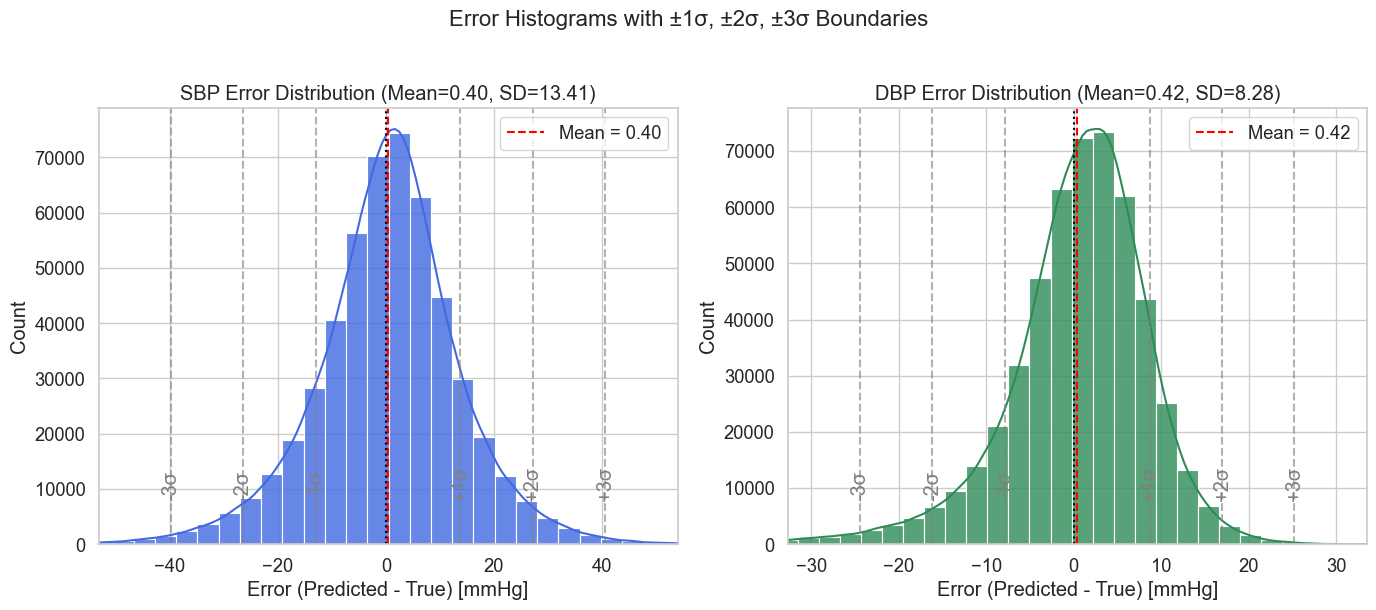

In [18]:
import seaborn as sns

# ✅ Ensure numpy arrays
if torch.is_tensor(y_true):
    y_true = y_true.cpu().numpy()
if torch.is_tensor(y_pred):
    y_pred = y_pred.cpu().numpy()

# Compute errors
sbp_errors = y_pred[:, 0] - y_true[:, 0]
dbp_errors = y_pred[:, 1] - y_true[:, 1]

# Compute mean & std
sbp_mean, sbp_std = np.mean(sbp_errors), np.std(sbp_errors)
dbp_mean, dbp_std = np.mean(dbp_errors), np.std(dbp_errors)

sns.set(style="whitegrid", font_scale=1.2)
plt.figure(figsize=(14, 6))

# Helper function to annotate std lines
def plot_error_hist(errors, mean, std, title, color):
    sns.histplot(errors, bins=40, kde=True, color=color, alpha=0.8)
    plt.axvline(mean, color="red", linestyle="--", label=f"Mean = {mean:.2f}")

    # ±1σ, ±2σ, ±3σ lines with labels
    for i in range(1, 4):
        plt.axvline(mean + i*std, color="gray", linestyle="--", alpha=0.6)
        plt.axvline(mean - i*std, color="gray", linestyle="--", alpha=0.6)
        plt.text(mean + i*std, plt.ylim()[1]*0.10, f"+{i}σ", rotation=90, color="gray", va="bottom", ha="center")
        plt.text(mean - i*std, plt.ylim()[1]*0.10, f"-{i}σ", rotation=90, color="gray", va="bottom", ha="center")

    plt.axvline(0, color="black", linestyle=":")
    plt.title(title + f" (Mean={mean:.2f}, SD={std:.2f})")
    plt.xlim(mean - 4*std, mean + 4*std)
    plt.xlabel("Error (Predicted - True) [mmHg]")
    plt.ylabel("Count")
    plt.legend()

# ---------- SBP ----------
plt.subplot(1, 2, 1)
plot_error_hist(sbp_errors, sbp_mean, sbp_std, "SBP Error Distribution", "royalblue")

# ---------- DBP ----------
plt.subplot(1, 2, 2)
plot_error_hist(dbp_errors, dbp_mean, dbp_std, "DBP Error Distribution", "seagreen")

plt.suptitle("Error Histograms with ±1σ, ±2σ, ±3σ Boundaries", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

### Bland-Altman Plots for SBP and DBP

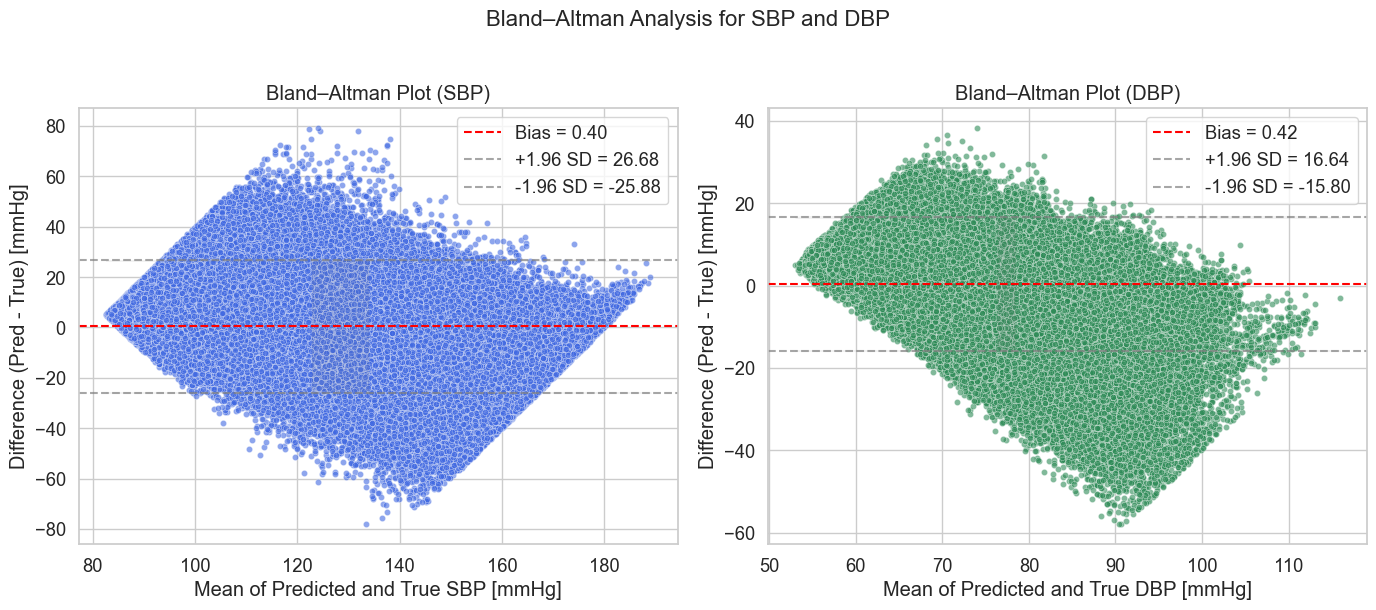

In [19]:

# ✅ Ensure numpy arrays
if torch.is_tensor(y_true):
    y_true = y_true.cpu().numpy()
if torch.is_tensor(y_pred):
    y_pred = y_pred.cpu().numpy()

# Compute means and differences
sbp_true, dbp_true = y_true[:, 0], y_true[:, 1]
sbp_pred, dbp_pred = y_pred[:, 0], y_pred[:, 1]

sbp_mean = (sbp_true + sbp_pred) / 2
dbp_mean = (dbp_true + dbp_pred) / 2

sbp_diff = sbp_pred - sbp_true
dbp_diff = dbp_pred - dbp_true

# Mean bias and limits of agreement (±1.96 SD)
sbp_bias = np.mean(sbp_diff)
dbp_bias = np.mean(dbp_diff)

sbp_sd = np.std(sbp_diff)
dbp_sd = np.std(dbp_diff)

sbp_upper = sbp_bias + 1.96 * sbp_sd
sbp_lower = sbp_bias - 1.96 * sbp_sd
dbp_upper = dbp_bias + 1.96 * dbp_sd
dbp_lower = dbp_bias - 1.96 * dbp_sd

sns.set(style="whitegrid", font_scale=1.2)
plt.figure(figsize=(14, 6))

# ---------- SBP ----------
plt.subplot(1, 2, 1)
sns.scatterplot(x=sbp_mean, y=sbp_diff, color="royalblue", alpha=0.6, s=20)
plt.axhline(sbp_bias, color="red", linestyle="--", label=f"Bias = {sbp_bias:.2f}")
plt.axhline(sbp_upper, color="gray", linestyle="--", alpha=0.7, label=f"+1.96 SD = {sbp_upper:.2f}")
plt.axhline(sbp_lower, color="gray", linestyle="--", alpha=0.7, label=f"-1.96 SD = {sbp_lower:.2f}")
plt.fill_between(sbp_mean, sbp_lower, sbp_upper, color="gray", alpha=0.1)
plt.title("Bland–Altman Plot (SBP)")
plt.xlabel("Mean of Predicted and True SBP [mmHg]")
plt.ylabel("Difference (Pred - True) [mmHg]")
plt.legend(loc="upper right")

# ---------- DBP ----------
plt.subplot(1, 2, 2)
sns.scatterplot(x=dbp_mean, y=dbp_diff, color="seagreen", alpha=0.6, s=20)
plt.axhline(dbp_bias, color="red", linestyle="--", label=f"Bias = {dbp_bias:.2f}")
plt.axhline(dbp_upper, color="gray", linestyle="--", alpha=0.7, label=f"+1.96 SD = {dbp_upper:.2f}")
plt.axhline(dbp_lower, color="gray", linestyle="--", alpha=0.7, label=f"-1.96 SD = {dbp_lower:.2f}")
plt.fill_between(dbp_mean, dbp_lower, dbp_upper, color="gray", alpha=0.1)
plt.title("Bland–Altman Plot (DBP)")
plt.xlabel("Mean of Predicted and True DBP [mmHg]")
plt.ylabel("Difference (Pred - True) [mmHg]")
plt.legend(loc="upper right")

plt.suptitle("Bland–Altman Analysis for SBP and DBP", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


## Inference Time

In [23]:
import time

# ✅ Function to measure inference time
def benchmark_inference(model, device, num_runs=1000):
    model.eval()
    model.to(device)
    window_len = 3 * 125  # 3 seconds @125 Hz
    sample = torch.randn(1, 1, window_len, dtype=torch.float32).to(device)

    # Warm-up (important especially for CUDA)
    with torch.no_grad():
        for _ in range(10):
            _ = model(sample)

    if device.type == "cuda":
        torch.cuda.synchronize()

    start = time.time()
    with torch.no_grad():
        for _ in range(num_runs):
            _ = model(sample)
    if device.type == "cuda":
        torch.cuda.synchronize()

    end = time.time()

    avg_time = (end - start) / num_runs
    fps = 1 / avg_time
    return avg_time, fps


# ✅ Run benchmarks for both GPU and CPU
for dev in ["cuda", "cpu"]:
    if dev == "cuda" and not torch.cuda.is_available():
        print("⚠️ CUDA not available, skipping GPU test.")
        continue

    device = torch.device(dev)
    avg_time, fps = benchmark_inference(model, device)

    print(f"\n⚡ Device: {device}")
    print(f"✅ Average inference time per 3-s PPG window: {avg_time*1000:.3f} ms")
    print(f"✅ Throughput: {fps:.1f} samples/sec ({fps/60:.2f} Hz real-time rate)")



⚡ Device: cuda
✅ Average inference time per 3-s PPG window: 1.160 ms
✅ Throughput: 862.3 samples/sec (14.37 Hz real-time rate)

⚡ Device: cpu
✅ Average inference time per 3-s PPG window: 0.540 ms
✅ Throughput: 1851.4 samples/sec (30.86 Hz real-time rate)
